/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


(100000, 9)
{'gender': 0, 'age': 0, 'hypertension': 0, 'heart_disease': 0, 'smoking_history': 0, 'bmi': 0, 'HbA1c_level': 0, 'blood_glucose_level': 0, 'diabetes': 0}
Decision Tree (max_depth=2) ROC AUC: 0.8388235294117647


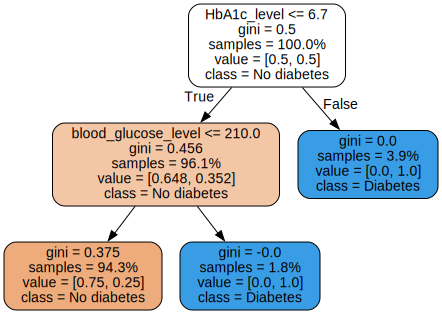

Fitting 4 folds for each of 8 candidates, totalling 32 fits
Best params (DecisionTree): {'dt__max_depth': 8}
Best CV ROC AUC: 0.9735952587592414


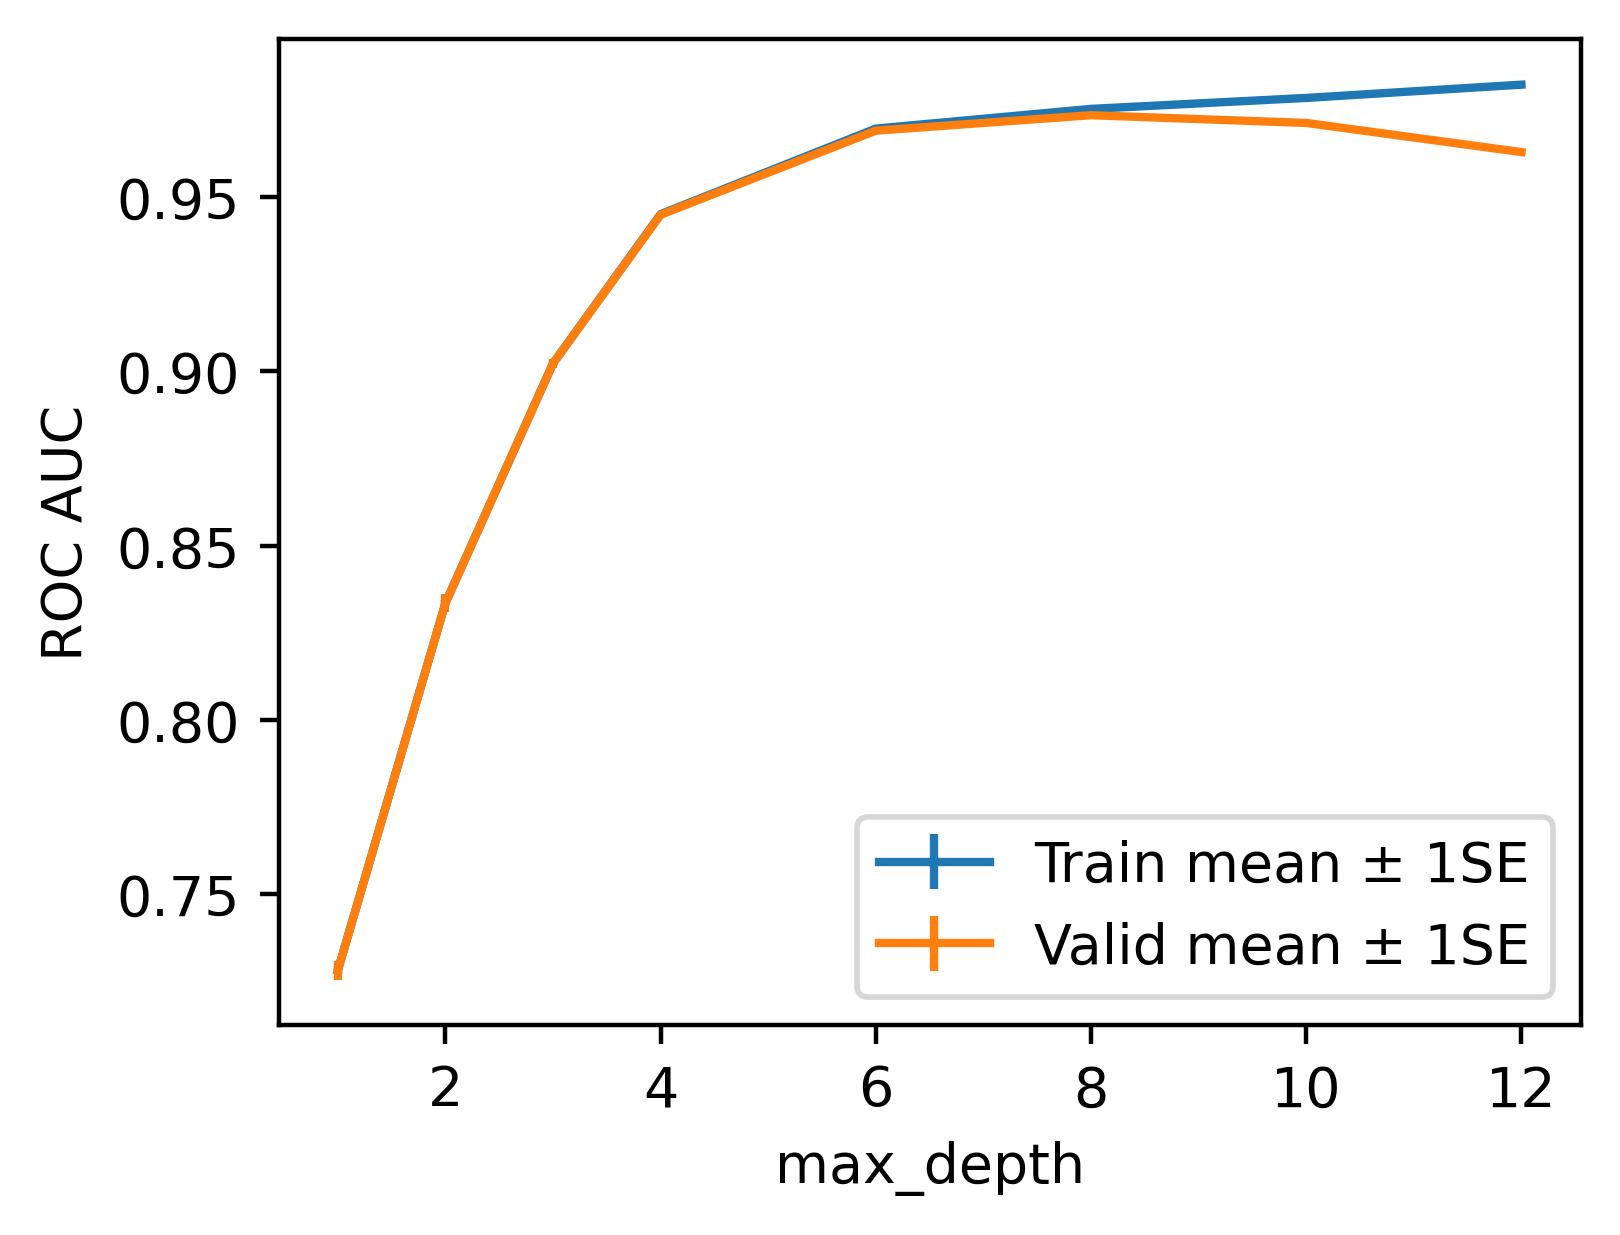

DecisionTree (best) Valid ROC AUC: 0.9724264223722277
RandomForest (n_estimators=10, max_depth=3) Valid ROC AUC: 0.9585134201221472
Fitting 4 folds for each of 10 candidates, totalling 40 fits


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Best params (RF): {'rf__n_estimators': 40}
Best CV ROC AUC (RF): 0.9684330400192864


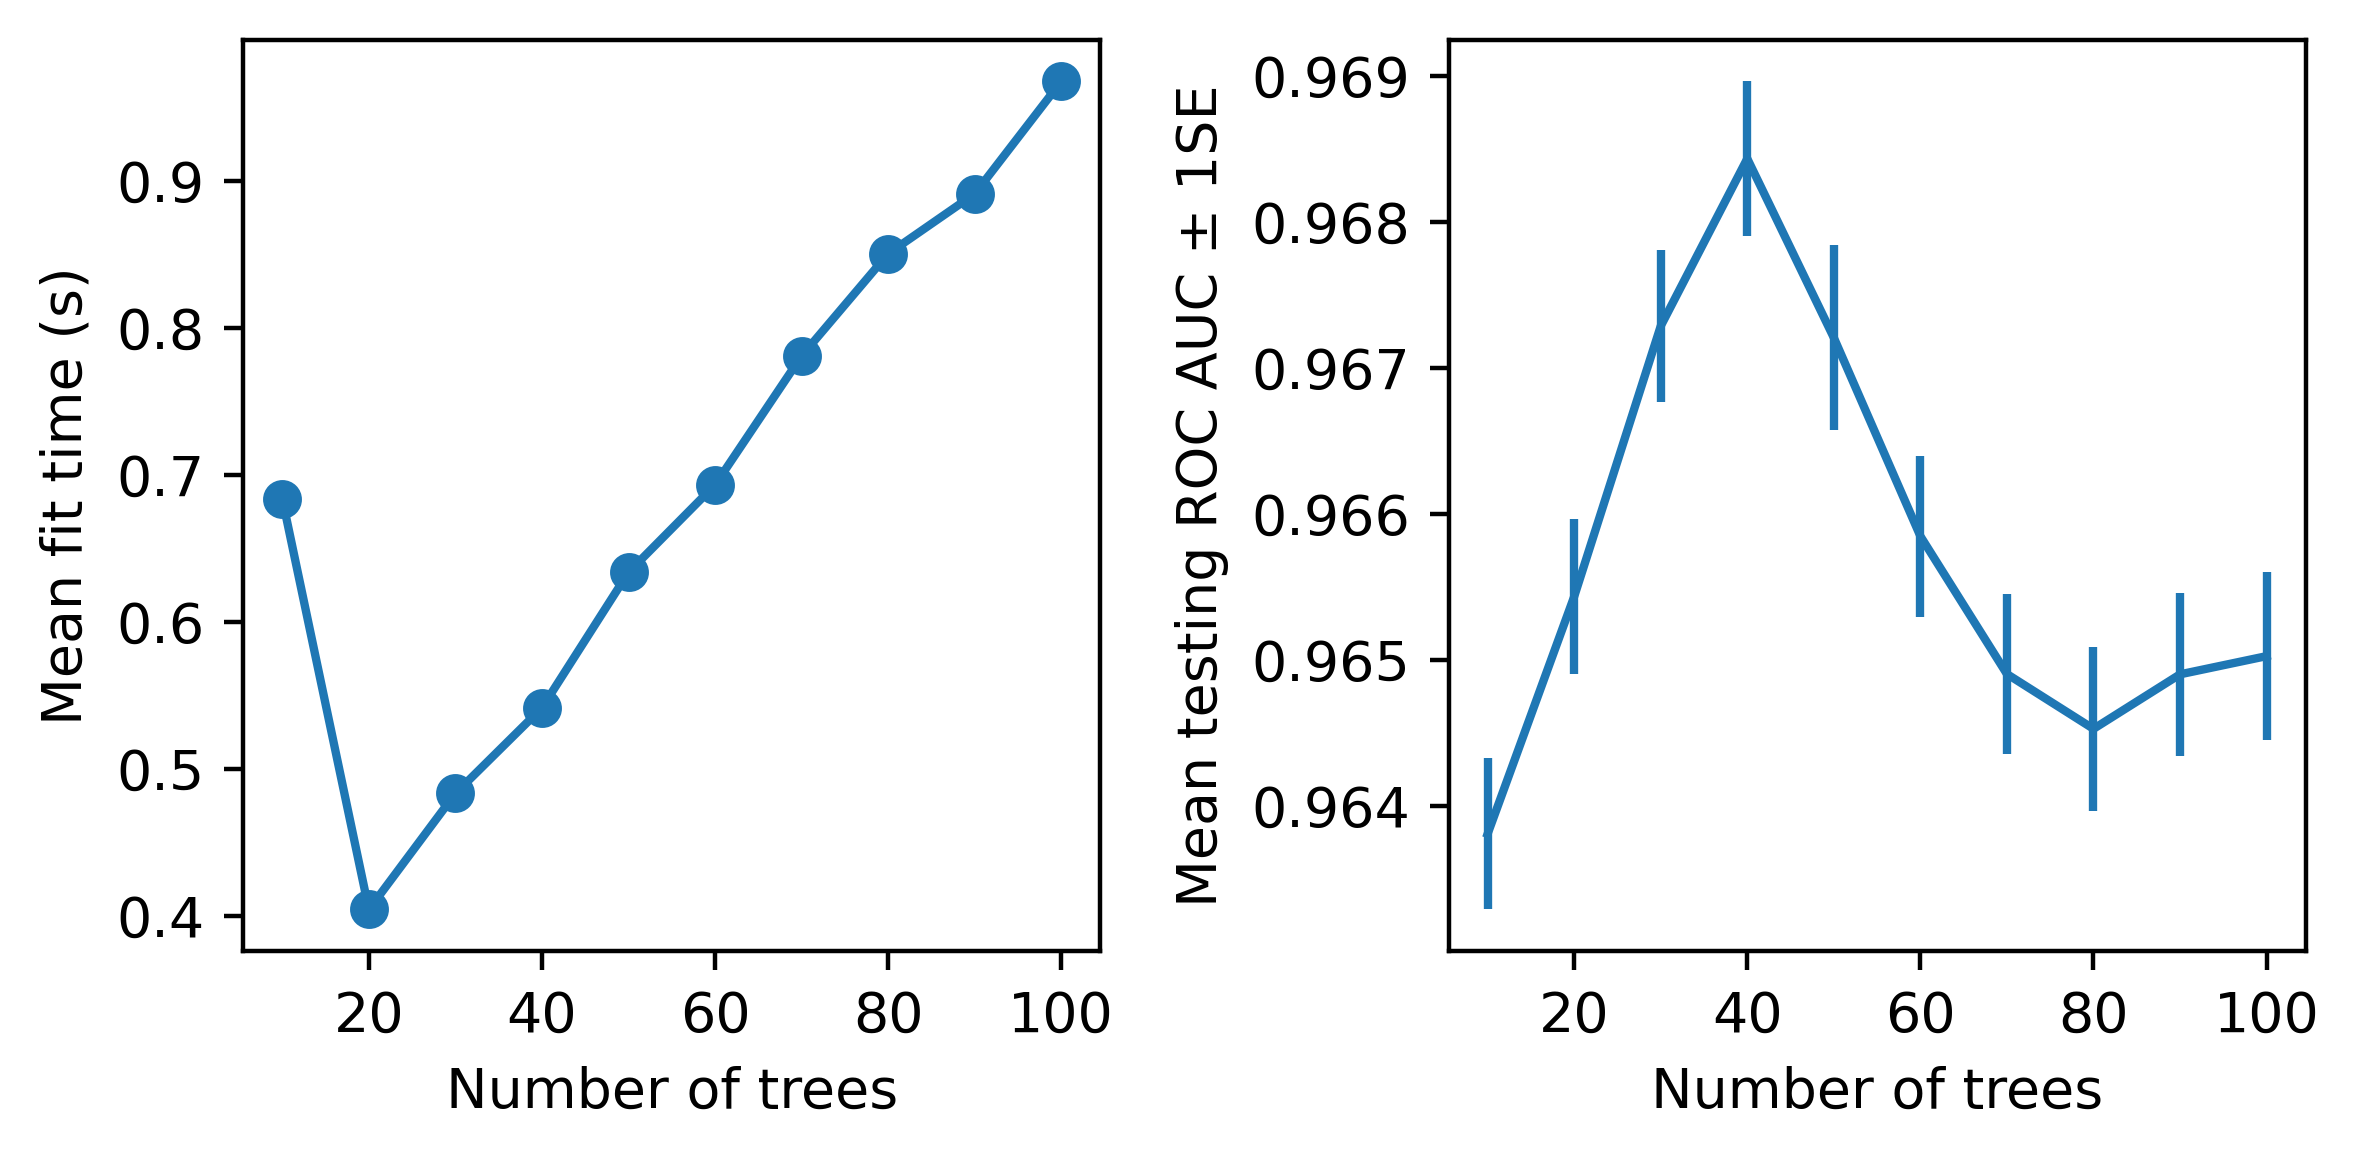

RandomForest (best) Valid ROC AUC: 0.9657529733204757


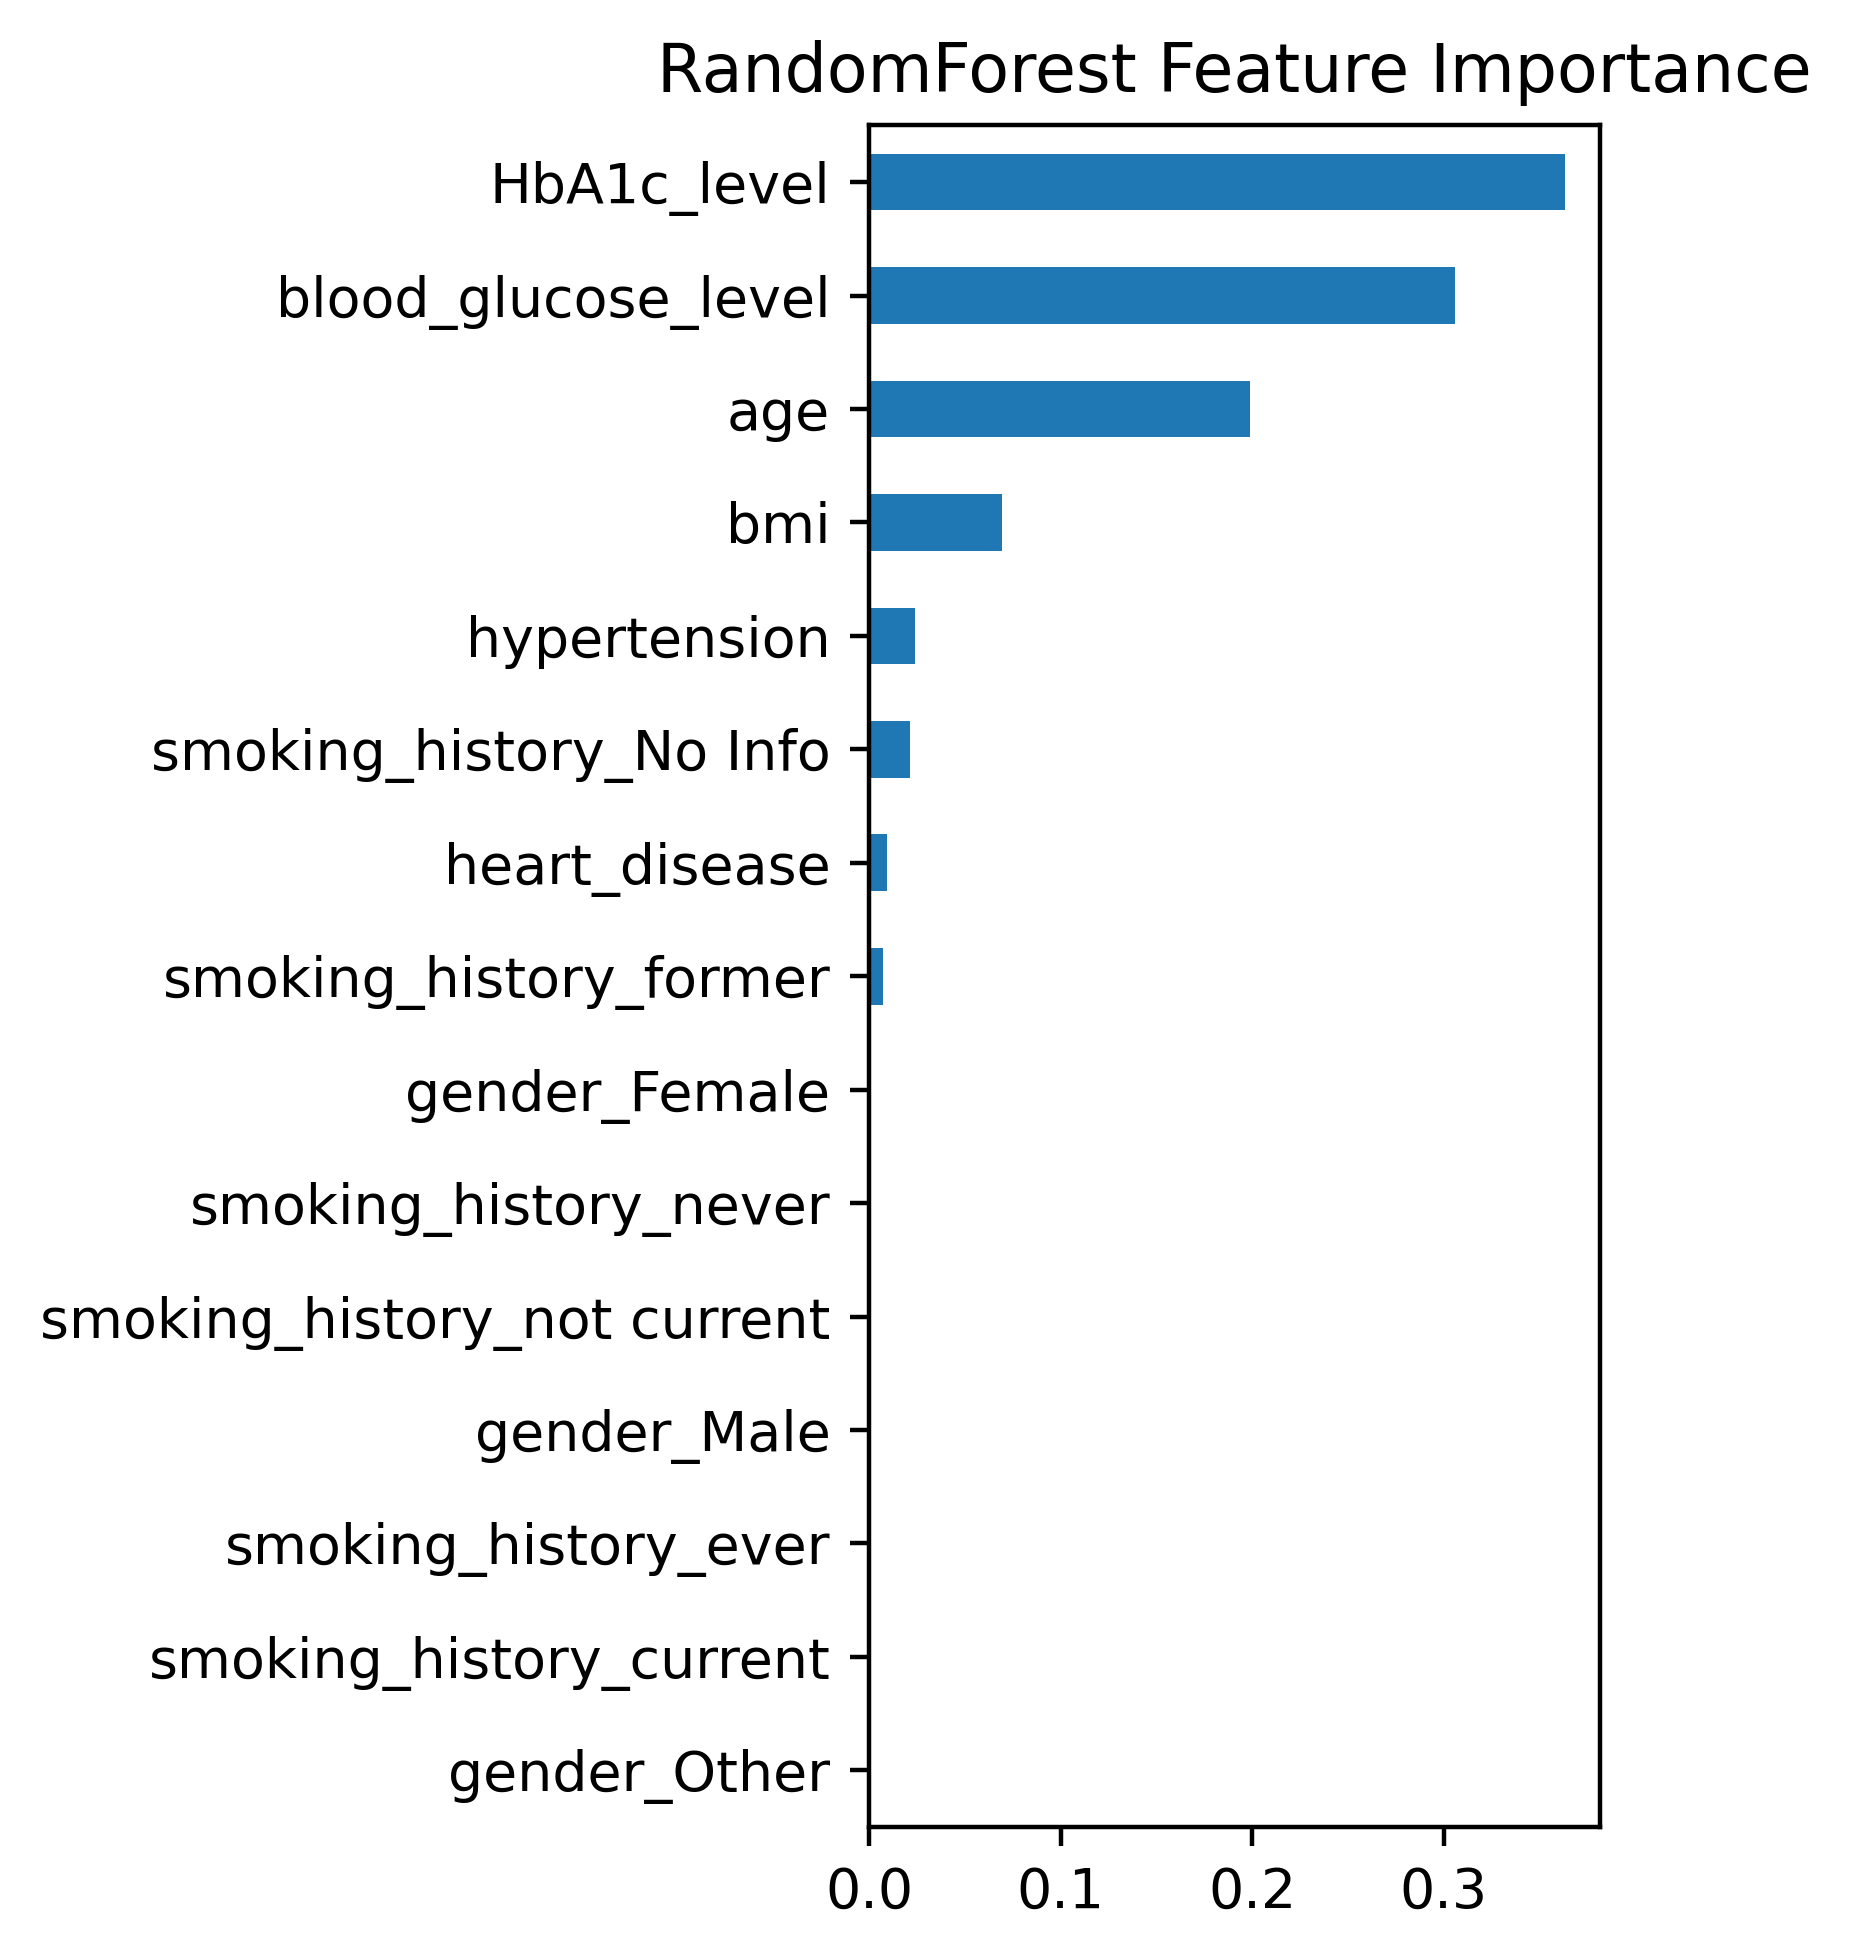

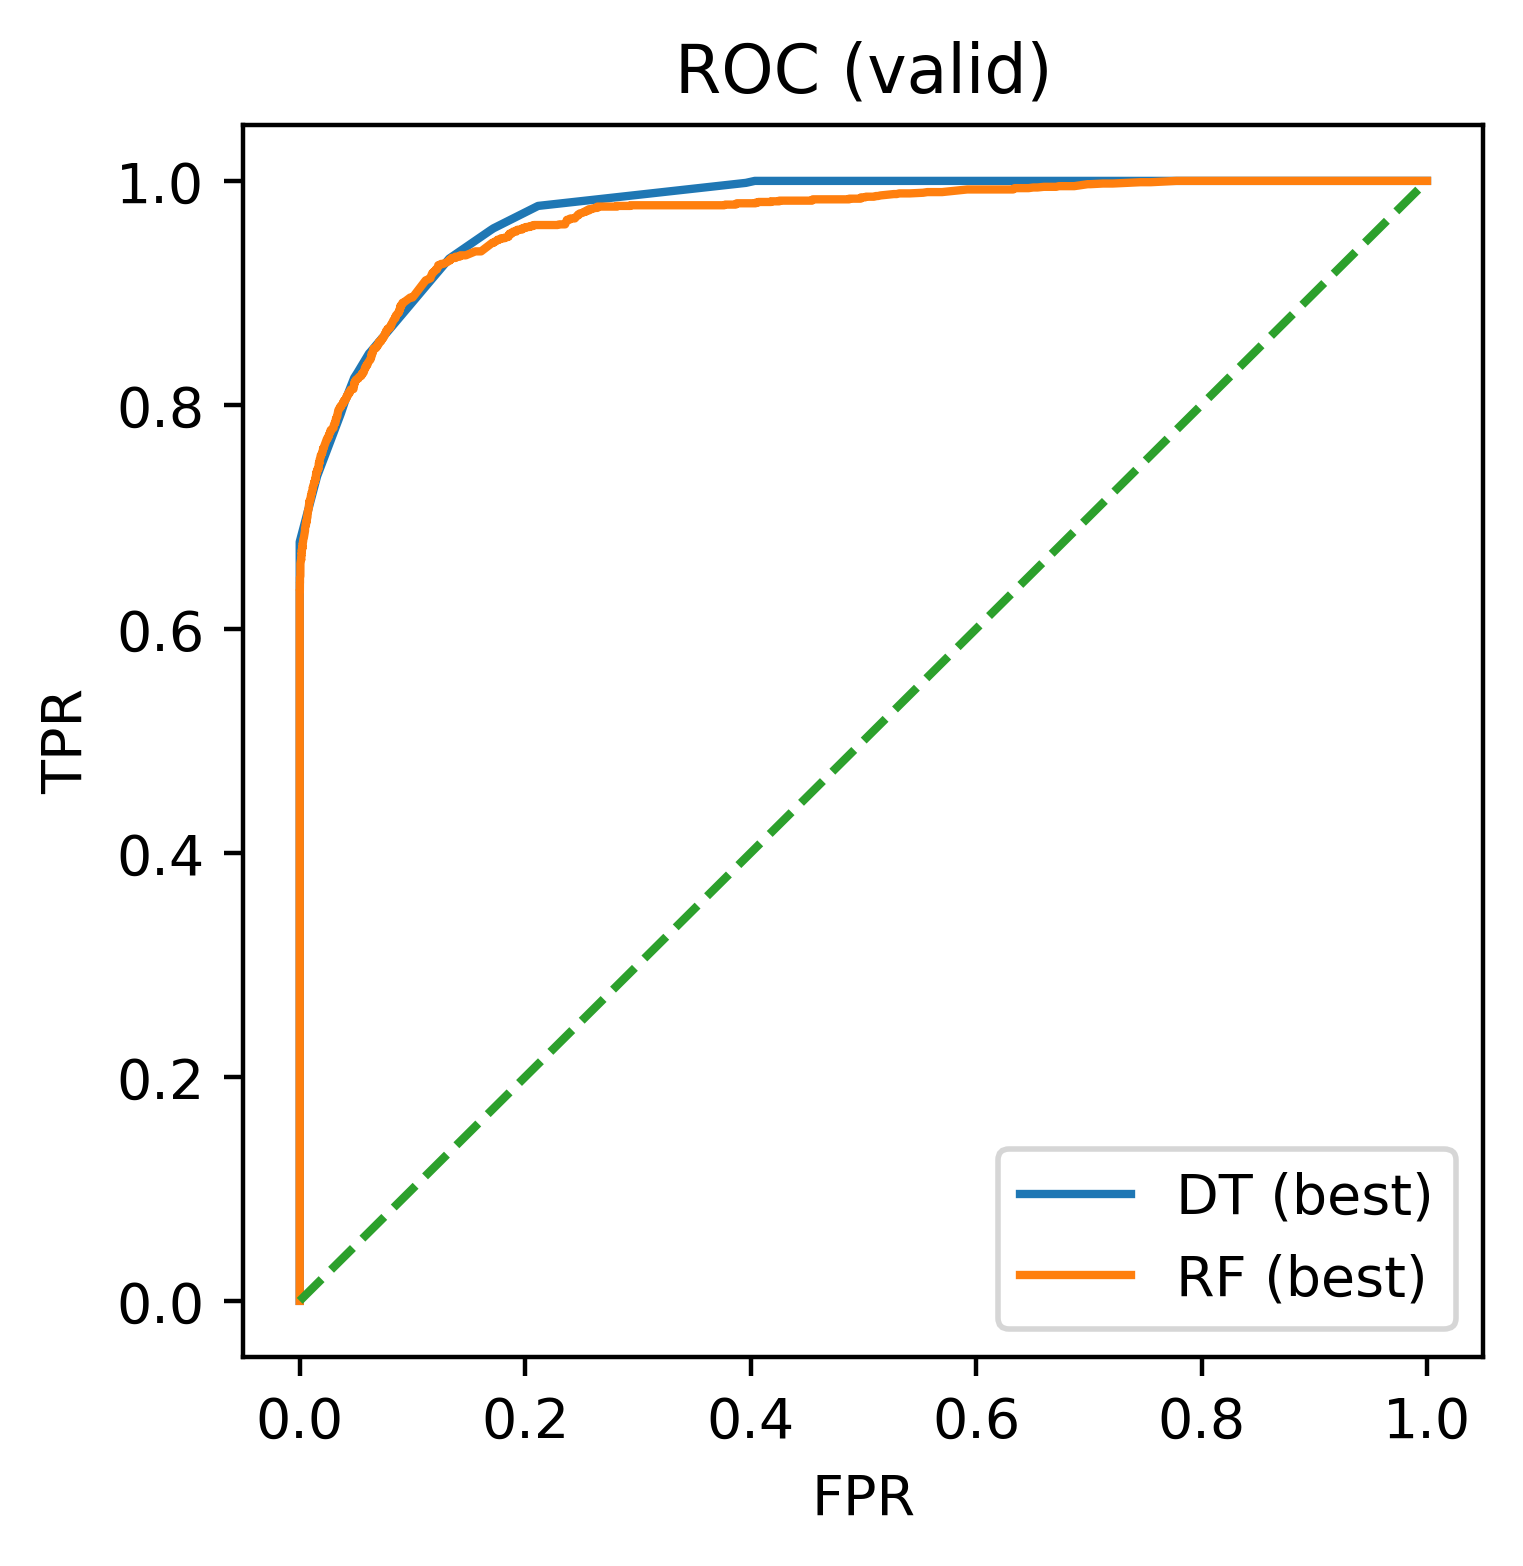

In [1]:
# =========================
# 0) CÀI & IMPORT GÓI  (tương ứng Step 1 trong tài liệu)
# =========================
# !pip install graphviz --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400

import graphviz
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import tree
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn import set_config

RANDOM_STATE = 24

# =========================
# 1) NẠP DỮ LIỆU & CHỌN BIẾN  (Step 2 trong tài liệu)
# =========================
CSV_PATH = "/kaggle/input/diabetes-prediction-dataset/diabetes_prediction_dataset.csv"   # <-- thay đường dẫn nếu cần
df = pd.read_csv(CSV_PATH)

# Kiểm tra nhanh thiếu dữ liệu
print(df.shape)
print(df.isna().sum().to_dict())

# Tên cột mục tiêu & đặc trưng
target_col = "diabetes"
feature_cols = [
    "gender", "age", "hypertension", "heart_disease",
    "smoking_history", "bmi", "HbA1c_level", "blood_glucose_level"
]

# (Tùy chọn) Feature engineering nhẹ — ví dụ BMI nhóm, hoặc tương tác:
# Ở đây giữ đơn giản theo yêu cầu bài lab 2.1

X = df[feature_cols].copy()
y = df[target_col].astype(int).copy()

# =========================
# 2) TIỀN XỬ LÝ & TÁCH TẬP  (Step 3 trong tài liệu)
# =========================
num_cols = ["age","bmi","HbA1c_level","blood_glucose_level"]
bin_cols = ["hypertension","heart_disease"]  # nhị phân 0/1 -> coi là số hoặc category đều được
cat_cols = ["gender","smoking_history"]

# Bảo đảm OHE trả về dense để tránh lỗi pandas+sparse khi export Graphviz
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)  # sklearn >=1.2
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)         # sklearn <1.2

numeric_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])
binary_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent"))
])
categorical_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe)
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_tf, num_cols),
        ("bin", binary_tf, bin_cols),
        ("cat", categorical_tf, cat_cols),
    ]
)

# Tách tập train/valid (giữ tỉ lệ lớp bằng stratify)
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# =========================
# 3) CÂY QUYẾT ĐỊNH  (Step 4–5 trong tài liệu)
# =========================
dt = tree.DecisionTreeClassifier(max_depth=2, class_weight="balanced", random_state=RANDOM_STATE)

dt_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("dt", dt)
])

dt_pipe.fit(X_train, y_train)
y_valid_proba_dt = dt_pipe.predict_proba(X_valid)[:, 1]
print("Decision Tree (max_depth=2) ROC AUC:", roc_auc_score(y_valid, y_valid_proba_dt))

# ---- VẼ CÂY BẰNG GRAPHVIZ (Hình 2.1) ----
# Dùng set_config để lấy DataFrame sau transform (cần OHE dense)
set_config(transform_output="pandas")
X_train_tx = preprocess.fit_transform(X_train)  # fit để lấy đúng tên cột
true_dt = tree.DecisionTreeClassifier(max_depth=2, class_weight="balanced", random_state=RANDOM_STATE)
true_dt.fit(X_train_tx, y_train)

# Lấy tên cột sau preprocess
ohe_fitted = preprocess.named_transformers_["cat"].named_steps["ohe"]
num_names = num_cols
bin_names = bin_cols
cat_names = list(ohe_fitted.get_feature_names_out(cat_cols))
all_feature_names = num_names + bin_names + cat_names

dot = tree.export_graphviz(
    true_dt,
    out_file=None,
    filled=True,
    rounded=True,
    feature_names=all_feature_names,
    proportion=True,
    class_names=["No diabetes","Diabetes"]
)
graph = graphviz.Source(dot)
display(graph)

# =========================
# 4) GRIDSEARCHCV: TỐI ƯU max_depth  (Nhiệm vụ 2 — Step 2–3)
# =========================
params_dt = {"dt__max_depth":[1,2,3,4,6,8,10,12]}
grid_dt = Pipeline(steps=[("prep", preprocess),
                         ("dt", tree.DecisionTreeClassifier(class_weight="balanced", random_state=RANDOM_STATE))])

cv_dt = GridSearchCV(
    grid_dt,
    param_grid=params_dt,
    scoring="roc_auc",
    cv=4, refit=True, return_train_score=True, verbose=1
)
cv_dt.fit(X_train, y_train)

print("Best params (DecisionTree):", cv_dt.best_params_)
print("Best CV ROC AUC:", cv_dt.best_score_)

# Biểu đồ mean ± 1SE theo max_depth (Hình 2.2)
cvdf = pd.DataFrame(cv_dt.cv_results_)
k = 4
fig, ax = plt.subplots(figsize=(4.2,3.2))
ax.errorbar(cvdf["param_dt__max_depth"], cvdf["mean_train_score"],
            yerr=cvdf["std_train_score"]/np.sqrt(k), label="Train mean ± 1SE")
ax.errorbar(cvdf["param_dt__max_depth"], cvdf["mean_test_score"],
            yerr=cvdf["std_test_score"]/np.sqrt(k), label="Valid mean ± 1SE")
ax.set_xlabel("max_depth"); ax.set_ylabel("ROC AUC"); ax.legend(); plt.show()

# Đánh giá trên hold-out valid
y_valid_proba_dt_best = cv_dt.predict_proba(X_valid)[:,1]
print("DecisionTree (best) Valid ROC AUC:", roc_auc_score(y_valid, y_valid_proba_dt_best))

# =========================
# 5) RANDOM FOREST  (Nhiệm vụ 3 — Step 2–5)
# =========================
rf = RandomForestClassifier(
    n_estimators=10, criterion="gini", max_depth=3,
    min_samples_split=2, min_samples_leaf=1, max_features="sqrt",
    bootstrap=True, oob_score=False, class_weight="balanced",
    random_state=RANDOM_STATE, n_jobs=-1
)

rf_pipe = Pipeline(steps=[("prep", preprocess), ("rf", rf)])
rf_pipe.fit(X_train, y_train)
y_valid_proba_rf = rf_pipe.predict_proba(X_valid)[:,1]
print("RandomForest (n_estimators=10, max_depth=3) Valid ROC AUC:",
      roc_auc_score(y_valid, y_valid_proba_rf))

# ---- GridSearch số cây giống tài liệu ----
rf_grid = {"rf__n_estimators": list(range(10,110,10))}
cv_rf = GridSearchCV(
    Pipeline(steps=[("prep", preprocess),
                   ("rf", RandomForestClassifier(
                        criterion="gini", max_depth=3,
                        min_samples_split=2, min_samples_leaf=1,
                        max_features="sqrt", bootstrap=True,
                        class_weight="balanced",
                        random_state=RANDOM_STATE, n_jobs=-1
                   ))]),
    param_grid=rf_grid, scoring="roc_auc",
    cv=4, refit=True, return_train_score=True, verbose=1
)
cv_rf.fit(X_train, y_train)

print("Best params (RF):", cv_rf.best_params_)
print("Best CV ROC AUC (RF):", cv_rf.best_score_)

# Biểu đồ (số cây vs thời gian fit & ROC AUC) — Hình 2.3
rf_res = pd.DataFrame(cv_rf.cv_results_)
fig, axs = plt.subplots(1,2, figsize=(6,3))
axs[0].plot(rf_res["param_rf__n_estimators"], rf_res["mean_fit_time"], "-o")
axs[0].set_xlabel("Number of trees"); axs[0].set_ylabel("Mean fit time (s)")
axs[1].errorbar(rf_res["param_rf__n_estimators"], rf_res["mean_test_score"],
                yerr=rf_res["std_test_score"]/np.sqrt(4))
axs[1].set_xlabel("Number of trees"); axs[1].set_ylabel("Mean testing ROC AUC ± 1SE")
plt.tight_layout(); plt.show()

# Hold-out valid ROC AUC của mô hình RF tốt nhất
y_valid_proba_rf_best = cv_rf.predict_proba(X_valid)[:,1]
print("RandomForest (best) Valid ROC AUC:", roc_auc_score(y_valid, y_valid_proba_rf_best))

# =========================
# 6) FEATURE IMPORTANCE  (Step 5 trong tài liệu — Hình 2.4)
# =========================
best_rf_pipe = cv_rf.best_estimator_
best_rf = best_rf_pipe.named_steps["rf"]

preprocess_fitted = best_rf_pipe.named_steps["prep"]
ohe_fitted = preprocess_fitted.named_transformers_["cat"].named_steps["ohe"]
feat_names = num_cols + bin_cols + list(ohe_fitted.get_feature_names_out(cat_cols))

imp = pd.Series(best_rf.feature_importances_, index=feat_names).sort_values(ascending=True)
ax = imp.plot.barh(figsize=(4.2,5))
ax.set_title("RandomForest Feature Importance")
plt.tight_layout(); plt.show()

# =========================
# 7) (TUỲ CHỌN) SO SÁNH ROC CURVE (DT best vs RF best)
# =========================
def plot_roc(y_true, p1, label):
    fpr, tpr, _ = roc_curve(y_true, p1)
    plt.plot(fpr, tpr, label=label)

plt.figure(figsize=(4,4))
plot_roc(y_valid, y_valid_proba_dt_best, "DT (best)")
plot_roc(y_valid, y_valid_proba_rf_best, "RF (best)")
plt.plot([0,1],[0,1],"--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC (valid)"); plt.legend(); plt.show()
